In [14]:
import pandas as pd
from pyvi import ViTokenizer, ViPosTagger
import nltk
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

In [15]:
filename =["bạn bè.txt","các câu hỏi phức tạp.txt","du lịch.txt","gia đình.txt","giải trí.txt",
           "học tập.txt","nghề nghiệp.txt","nghỉ lễ.txt","người yêu.txt","robot.txt","shoping.txt",
           "sở thích.txt","tdtu.txt","thông tin cá nhân.txt","trò chuyện về đi ăn.txt","tán gẫu.txt","đất nước.txt","địa chỉ.txt"]

## 1. Import data

In [16]:
# import train data
temp_ques = []
temp_ans = []
tag = []
for k in range(len(filename)):
    with open('dataset/' + filename[k], encoding='utf-8') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith('__eou__'):
            continue
        else:
            part = lines[i].strip('__eou__').split('__eou__')
            temp_ques.append(ViTokenizer.tokenize(part[0].lower().strip()))
            temp_ans.append(ViTokenizer.tokenize(part[1].lower().strip()))
            tag.append(filename[k].split(".")[0])

In [17]:
data = pd.DataFrame({'Question':temp_ques,'Answer':temp_ans,'Tag':tag})
data.head()

,Question,Answer,Tag
0,thích đánh_lộn không ?,ngon nhà_vô,bạn bè
1,solo yasua không,chấp lun 2 mạng đầu,bạn bè
2,mai đi picnic không ?,mai bận học rồi,bạn bè
3,mai học ca mấy vậy ?,mai học ca 3,bạn bè
4,còn tiền không ?,còn chết liền,bạn bè


In [18]:
ques = np.array(data["Question"])
ans = np.array(data["Answer"])

## 2. Data preprocessing

In [19]:
lst_empty_answer_index = []
for i in range(len(ans)):
    if(ans[i] == ""):
        lst_empty_answer_index.append(i)

In [20]:
for i in lst_empty_answer_index:
    ques = np.delete(ques, i)
    ans = np.delete(ans, i)

In [21]:
def clean_sentences(sentences):
    Punc = {'.', ',', '...', '-', '“', '”', ':', '(', ')', '"', '!', '&', ';', '?', '*', ']', '>', '…', '’',"``","''"}
    for i, sent in enumerate(sentences):
        sent = sent.lower()
        
        sent = [char for char in sent if char not in Punc]
        sent = "".join(sent)
        
        sent = sent.replace("   ", " ")
        sent = sent.replace("  ", " ")
        sent = sent.strip()
        
        sentences[i] = sent
    return sentences

In [22]:
clean_ques = clean_sentences(ques)
clean_ans = clean_sentences(ans)

In [23]:
word2count = {}
for sent in clean_ques:
    for word in sent.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

for sent in clean_ans:
    for word in sent.split():
        if word not in word2count:
            word2count[word] = 1
        else:
            word2count[word] += 1

In [24]:
len(word2count)

4766

In [25]:
thresh = 1
word2index = {}
word_num = 0

for word, count in word2count.items():
    if (count >= thresh):
        word2index[word] = word_num
        word_num += 1

In [26]:
len(word2index)

4766

In [27]:
for i in range(len(clean_ans)):
    clean_ans[i] = '<BOS> ' + clean_ans[i] + ' <EOS>'

In [28]:
len(clean_ans)

5769

In [29]:
tokens = ['<BOS>', '<EOS>', '<OUT>']
x = len(word2index)
for token in tokens:
    word2index[token] = x
    x += 1

In [30]:
len(word2index)

4769

In [31]:
index2word = {w: v for v, w in word2index.items()}
len(index2word)

4769

In [32]:
encoder_input = []
for sent in clean_ques:
    lst = []
    for word in sent.split():
        if word not in word2index:
            lst.append(word2index["<OUT>"])
        else:
            lst.append(word2index[word])
    encoder_input.append(lst)

In [33]:
len(encoder_input)

5769

In [34]:
decoder_input = []
for sent in clean_ans:
    lst = []
    for word in sent.split():
        if word not in word2index:
            lst.append(word2index["<OUT>"])
        else:
            lst.append(word2index[word])
    decoder_input.append(lst)

In [35]:
len(decoder_input)

5769

## 3. BiLSTM Model

In [36]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 20
encoder_input = pad_sequences(encoder_input, MAX_LEN, padding='post', truncating='post')
decoder_input = pad_sequences(decoder_input, MAX_LEN, padding='post', truncating='post')

In [37]:
decoder_final_output = []
for i in decoder_input:
    decoder_final_output.append(i[1:])

In [38]:
decoder_final_output[:3]

[array([ 986, 2522, 4767,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]),
 array([2523, 2252,  453,  490,  474, 4767,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]),
 array([   5,  803,    8,   15, 4767,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])]

In [39]:
decoder_final_output = pad_sequences(decoder_final_output, MAX_LEN, padding='post', truncating='post')
decoder_final_output[:3]

array([[ 986, 2522, 4767,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [2523, 2252,  453,  490,  474, 4767,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   5,  803,    8,   15, 4767,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [40]:
from keras.utils import to_categorical
decoder_final_output = to_categorical(decoder_final_output, len(word2index))

In [41]:
decoder_final_output.shape

(5769, 20, 4769)

In [7]:
from keras.layers import Embedding, Bidirectional, Concatenate
from keras.layers import Input, Dense, LSTM, TimeDistributed
from keras.models import Model
from keras.callbacks import EarlyStopping

In [45]:
# Define input
enc_inp = Input(shape=(MAX_LEN, ))
dec_inp = Input(shape=(MAX_LEN, ))

VOCAB_SIZE = len(word2index)
HIDDEN_DIM = 200
embedding_dimention = 100

# Define embedding layer
embed = Embedding(VOCAB_SIZE + 1, output_dim = embedding_dimention, input_length = MAX_LEN, trainable = True)

In [41]:
# Define encoder layers
enc_embed = embed(enc_inp)
enc_lstm = Bidirectional(LSTM(HIDDEN_DIM, return_sequences = True, return_state = True))
enc_op, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_embed)

h = Concatenate()([forward_h, backward_h])
c = Concatenate()([forward_c, backward_c])
enc_states = [h, c]

#Define decoder layers
dec_embed = embed(dec_inp)
dec_lstm = LSTM(HIDDEN_DIM*2, return_sequences = True, return_state = True)
dec_op, _, _ = dec_lstm(dec_embed, initial_state = enc_states)

dense = Dense(VOCAB_SIZE, activation = "softmax")

dense_op = dense(dec_op)

model = Model([enc_inp, dec_inp], dense_op)

## 4. Train model

In [42]:
# Train model
model.compile(loss='categorical_crossentropy',metrics=['acc'],optimizer='adam')

BATCH_SIZE = 32
EPOCHS = 100

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history = model.fit([encoder_input, decoder_input],
                    decoder_final_output,
                    epochs=EPOCHS, 
                    callbacks=[es],
                    batch_size=BATCH_SIZE,
                    validation_data = ([encoder_input, decoder_input], decoder_final_output))

Epoch 1/100
181/181 [==============================] - 93s 511ms/step - loss: 2.8858 - acc: 0.6312 - val_loss: 2.2910 - val_acc: 0.6658
Epoch 2/100
181/181 [==============================] - 91s 503ms/step - loss: 2.2872 - acc: 0.6664 - val_loss: 2.2238 - val_acc: 0.6668
Epoch 3/100
181/181 [==============================] - 92s 510ms/step - loss: 2.2337 - acc: 0.6673 - val_loss: 2.1767 - val_acc: 0.6687
Epoch 4/100
181/181 [==============================] - 91s 504ms/step - loss: 2.1832 - acc: 0.6695 - val_loss: 2.1127 - val_acc: 0.6724
Epoch 5/100
181/181 [==============================] - 91s 500ms/step - loss: 2.1131 - acc: 0.6746 - val_loss: 2.0332 - val_acc: 0.6774
Epoch 6/100
181/181 [==============================] - 90s 499ms/step - loss: 2.0400 - acc: 0.6785 - val_loss: 1.9599 - val_acc: 0.6806
Epoch 7/100
181/181 [==============================] - 90s 500ms/step - loss: 1.9718 - acc: 0.6823 - val_loss: 1.8891 - val_acc: 0.6845
Epoch 8/100
181/181 [===========================

Epoch 61/100
181/181 [==============================] - 89s 493ms/step - loss: 0.1289 - acc: 0.9740 - val_loss: 0.1096 - val_acc: 0.9789
Epoch 62/100
181/181 [==============================] - 89s 492ms/step - loss: 0.1209 - acc: 0.9755 - val_loss: 0.1041 - val_acc: 0.9803
Epoch 63/100
181/181 [==============================] - 90s 495ms/step - loss: 0.1165 - acc: 0.9766 - val_loss: 0.1006 - val_acc: 0.9812
Epoch 64/100
181/181 [==============================] - 90s 495ms/step - loss: 0.1107 - acc: 0.9779 - val_loss: 0.0951 - val_acc: 0.9826
Epoch 65/100
181/181 [==============================] - 91s 500ms/step - loss: 0.1068 - acc: 0.9789 - val_loss: 0.0913 - val_acc: 0.9829
Epoch 66/100
181/181 [==============================] - 89s 492ms/step - loss: 0.1031 - acc: 0.9799 - val_loss: 0.0863 - val_acc: 0.9843
Epoch 67/100
181/181 [==============================] - 89s 494ms/step - loss: 0.0968 - acc: 0.9808 - val_loss: 0.0807 - val_acc: 0.9856
Epoch 68/100
181/181 [===================

In [3]:
model.save("Bidirectional_model.h5")

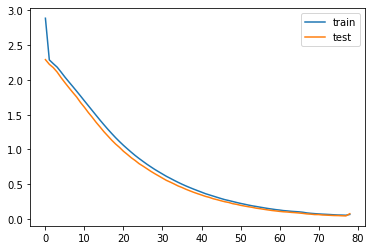

In [44]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [4]:
import keras.models
model = keras.models.load_model("Bidirectional_model.h5")

In [5]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 100)      477000      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) [(None, 20, 400), (N 481600      embedding_1[0][0]     

## 6. Inference process

In [46]:
embed = model.layers[2] #Embedding layer
enc_lstm = model.layers[3] # Bidirectional layer

#Load encoder model
enc_inp = model.input[0]
enc_embed = embed(enc_inp)
enc_op, forward_h, forward_c, backward_h, backward_c = enc_lstm(enc_embed)
h = Concatenate()([forward_h, backward_h])
c = Concatenate()([forward_c, backward_c])
enc_states = [h, c]

enc_model = Model([enc_inp], enc_states)

In [47]:
#Load decoder model to predict next word
decoder_state_input_h = Input(shape=(HIDDEN_DIM*2,))
decoder_state_input_c = Input(shape=(HIDDEN_DIM*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_inp = model.input[0]
dec_embed = embed(dec_inp)
dec_lstm = model.layers[6] # Decoder layer
dense = model.layers[7] # Dense

decoder_outputs, state_h, state_c = dec_lstm(dec_embed , initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
# output = dense(decoder_outputs)

dec_model = Model([dec_inp]+ decoder_states_inputs, [decoder_outputs] + decoder_states)

In [48]:
def clean_one_sent(sent):
    Punc = {'.', ',', '...', '-', '“', '”', ':', '(', ')', '"', '!', '&', ';', '?', '*', ']', '>', '…', '’',"``","''"}
    sent = sent.lower()

    sent = [char for char in sent if char not in Punc]
    sent = "".join(sent)

    sent = sent.replace("   ", " ")
    sent = sent.replace("  ", " ")
    sent = sent.strip()

    sent = ViTokenizer.tokenize(sent)
    
    return sent

In [49]:
prepro1 = ""
while prepro1 != 'quit':
    prepro1  = input("Question : ")
    prepro1 = clean_one_sent(prepro1)
    prepro = [prepro1]
    txt = []
    for x in prepro:
        lst = []
        for y in x.split():
            try:
                lst.append(word2index[y])
            except:
                lst.append(word2index['<OUT>'])
        txt.append(lst)
        txt = pad_sequences(txt, MAX_LEN, padding='post')

    stat = enc_model.predict( txt )
    empty_target_seq = np.zeros( ( 1 , 1) )
    empty_target_seq[0, 0] = word2index['<BOS>']
    stop_condition = False

    decoded_translation = ''

    while not stop_condition :
        dec_outputs , h, c= dec_model.predict([empty_target_seq] + stat )
        decoder_concat_input = dense(dec_outputs)
        sampled_word_index = np.argmax( decoder_concat_input[0, -1, :] )
        sampled_word = index2word[sampled_word_index] + ' '

        if sampled_word != '<EOS> ':
            decoded_translation += sampled_word
        if sampled_word == '<EOS> ' or len(decoded_translation.split()) > MAX_LEN+1:
            stop_condition = True

        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index

        stat = [h, c]
    print("Answer : ", decoded_translation )

Question : bạn có crush chưa ?
Answer :  mình có rồi 
Question : solo yasou không ?
Answer :  bạn phải thành_đạt trước đã 
Question : bạn hay uống cafe ở đâu ?
Answer :  mình thường hay hẹn_hò ở công_viên bạn nhé 
Question : quit
Answer :  
